# Football Player Rating Classification

In this project, we divide football player ratings into four qualitative categories:
- Very Poor (1-4)
- Poor (4-6)
- Good (6-8)
- Excellent (8-10)

Then, using various machine learning algorithms, we examine and compare the performance of different classification models.

## 1. Importing Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Loading and Initial Data Exploration

In [20]:
# Loading data
df = pd.read_csv('../data/data_football_ratings.csv')

print("Data shape:", df.shape)
print("\nGeneral information:")
df.info()

Data shape: (50652, 63)

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64

In [21]:
# Displaying sample data
print("Sample data:")
df.head()

Sample data:


,competition,date,match,team,pos,pos_role,player,rater,is_human,original_rating,...,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,win,lost,is_home_team,minutesPlayed,game_duration
0,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,Kicker,1,3.50,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
1,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,WhoScored,0,6.56,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
2,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,SofaScore,0,6.70,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
3,Euro 2016,10/06/2016,"France - Romania, 2 - 1",France,Sub,Sub,Anthony Martial,WhoScored,0,6.19,...,0.051556,0.524845,0.041096,0.166667,0.0,1,0,1,13,90
4,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,MF,DMC,Mihai Pintilii,Kicker,1,3.50,...,0.333284,0.710084,0.347826,0.675075,0.0,0,1,0,90,90


In [22]:
# Examining the distribution of original ratings
print("Descriptive statistics for original_rating:")
print(df['original_rating'].describe())

print(f"\nMinimum rating: {df['original_rating'].min()}")
print(f"Maximum rating: {df['original_rating'].max()}")
print(f"Number of unique values: {df['original_rating'].nunique()}")

Descriptive statistics for original_rating:
count    50652.000000
mean         5.687847
std          1.673356
min          1.000000
25%          4.500000
50%          6.040000
75%          7.000000
max         10.000000
Name: original_rating, dtype: float64

Minimum rating: 1.0
Maximum rating: 10.0
Number of unique values: 515


## 3. Visualizing Rating Distribution

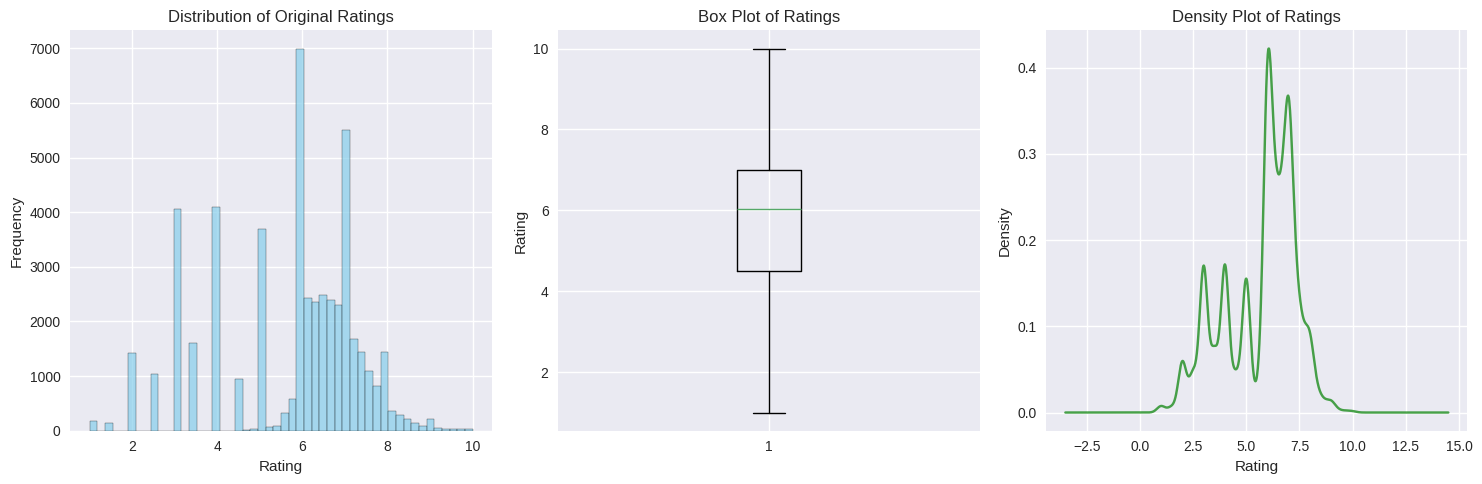

In [23]:
# Distribution plot of original ratings
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['original_rating'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Original Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(df['original_rating'])
plt.title('Box Plot of Ratings')
plt.ylabel('Rating')

plt.subplot(1, 3, 3)
df['original_rating'].plot(kind='density', color='green', alpha=0.7)
plt.title('Density Plot of Ratings')
plt.xlabel('Rating')

plt.tight_layout()
plt.show()

## 4. Creating Target Classes

In [24]:
# Define function to convert rating to class
def categorize_rating(rating):
    if rating < 4:
        return 'Very Poor'
    elif rating < 6:
        return 'Poor'
    elif rating < 8:
        return 'Good'
    else:
        return 'Excellent'

# Apply function to rating column
df['rating_category'] = df['original_rating'].apply(categorize_rating)

# Display class distribution
print("Rating class distribution:")
category_counts = df['rating_category'].value_counts()
print(category_counts)

print("\nPercentage of each class:")
print(df['rating_category'].value_counts(normalize=True) * 100)

Rating class distribution:
rating_category
Good         28858
Poor         10936
Very Poor     8448
Excellent     2410
Name: count, dtype: int64

Percentage of each class:
rating_category
Good         56.973071
Poor         21.590460
Very Poor    16.678512
Excellent     4.757956
Name: proportion, dtype: float64


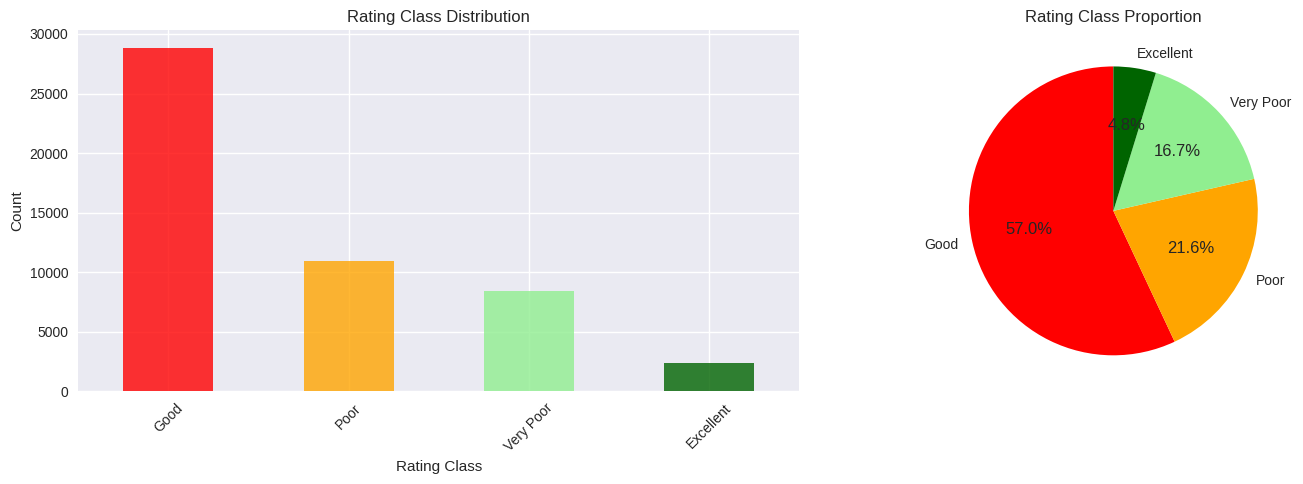

In [25]:
# Visualizing class distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
category_counts.plot(kind='bar', color=['red', 'orange', 'lightgreen', 'darkgreen'], alpha=0.8)
plt.title('Rating Class Distribution')
plt.xlabel('Rating Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
        colors=['red', 'orange', 'lightgreen', 'darkgreen'], startangle=90)
plt.title('Rating Class Proportion')

plt.tight_layout()
plt.show()

## 5. Feature Selection and Preparation

In [26]:
# View available columns
print("Available columns in dataset:")
print(df.columns.tolist())

Available columns in dataset:
['competition', 'date', 'match', 'team', 'pos', 'pos_role', 'player', 'rater', 'is_human', 'original_rating', 'goals', 'assists', 'shots_ontarget', 'shots_offtarget', 'shotsblocked', 'chances2score', 'drib_success', 'drib_unsuccess', 'keypasses', 'touches', 'passes_acc', 'passes_inacc', 'crosses_acc', 'crosses_inacc', 'lballs_acc', 'lballs_inacc', 'grduels_w', 'grduels_l', 'aerials_w', 'aerials_l', 'poss_lost', 'fouls', 'wasfouled', 'clearances', 'stop_shots', 'interceptions', 'tackles', 'dribbled_past', 'tballs_acc', 'tballs_inacc', 'ycards', 'rcards', 'dangmistakes', 'countattack', 'offsides', 'goals_ag_otb', 'goals_ag_itb', 'saves_itb', 'saves_otb', 'saved_pen', 'missed_penalties', 'owngoals', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'flow_centrality', 'flow_success', 'betweenness2goals', 'win', 'lost', 'is_home_team', 'minutesPlayed', 'game_duration', 'rating_category']


In [27]:
# Select numerical features related to player performance
numerical_features = [
    'goals', 'assists', 'shots_ontarget', 'shots_offtarget', 'shotsblocked',
    'chances2score', 'drib_success', 'drib_unsuccess', 'keypasses', 'touches',
    'passes_acc', 'passes_inacc', 'crosses_acc', 'crosses_inacc',
    'lballs_acc', 'lballs_inacc', 'grduels_w', 'grduels_l',
    'aerials_w', 'aerials_l', 'poss_lost', 'fouls', 'wasfouled',
    'clearances', 'stop_shots', 'interceptions', 'tackles', 'dribbled_past',
    'tballs_acc', 'tballs_inacc', 'ycards', 'rcards', 'dangmistakes',
    'countattack', 'offsides', 'minutesPlayed'
]

# Select desired features
features_df = df[numerical_features + ['rating_category']].copy()

# Check for missing values
print("Missing values in each column:")
missing_values = features_df.isnull().sum()
print(missing_values[missing_values > 0])

# Fill missing values with mean
features_df[numerical_features] = features_df[numerical_features].fillna(features_df[numerical_features].mean())

print(f"\nFinal data shape: {features_df.shape}")

Missing values in each column:
Series([], dtype: int64)

Final data shape: (50652, 37)


## 6. Feature Correlation Analysis

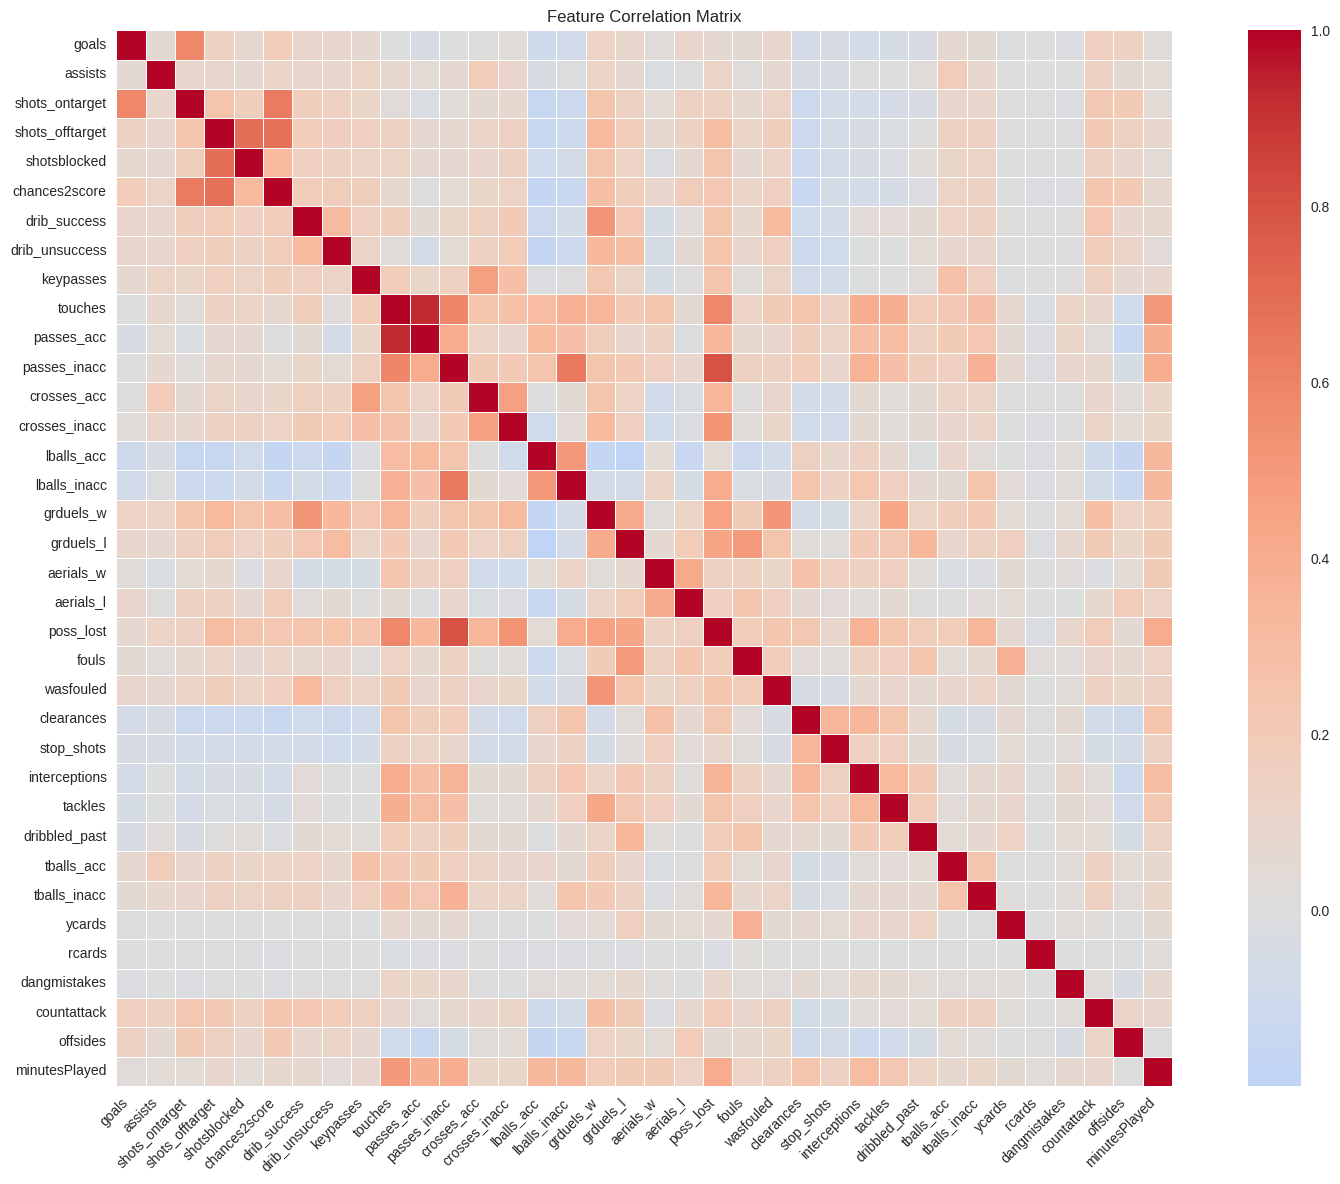

In [28]:
# Calculate correlation matrix
correlation_matrix = features_df[numerical_features].corr()

# Display correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Data Preparation for Modeling

In [29]:
# Separate features and target
X = features_df[numerical_features]
y = features_df['rating_category']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData has been normalized.")

Training set size: (40521, 36)
Test set size: (10131, 36)

Data has been normalized.


## 8. Defining and Training Different Models

In [30]:
# Define different models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Store results
results = {}

print("Starting model training...\n")

for name, model in models.items():
    print(f"Training {name} model...")
    
    # Train model
    if name in ['SVM', 'Logistic Regression', 'K-Nearest Neighbors']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print("-" * 40)

Starting model training...

Training Random Forest model...
Accuracy: 0.4935
----------------------------------------
Training Gradient Boosting model...
Accuracy: 0.4935
----------------------------------------
Training Gradient Boosting model...
Accuracy: 0.5840
----------------------------------------
Training SVM model...
Accuracy: 0.5840
----------------------------------------
Training SVM model...
Accuracy: 0.5776
----------------------------------------
Training Logistic Regression model...
Accuracy: 0.5776
----------------------------------------
Training Logistic Regression model...
Accuracy: 0.5812
----------------------------------------
Training K-Nearest Neighbors model...
Accuracy: 0.5812
----------------------------------------
Training K-Nearest Neighbors model...
Accuracy: 0.5335
----------------------------------------
Training Naive Bayes model...
Accuracy: 0.3468
----------------------------------------
Training Decision Tree model...
Accuracy: 0.5335
-------------

## 9. Model Performance Comparison

In [31]:
# Create DataFrame for comparing results
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()]
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("Model comparison results:")
print(comparison_df.round(4))

Model comparison results:
                 Model  Accuracy  Precision  Recall  F1-Score
0    Gradient Boosting    0.5840     0.5326  0.5840    0.4663
1  Logistic Regression    0.5812     0.5228  0.5812    0.4593
2                  SVM    0.5776     0.5129  0.5776    0.4476
3  K-Nearest Neighbors    0.5335     0.4841  0.5335    0.4915
4        Random Forest    0.4935     0.4717  0.4935    0.4796
5        Decision Tree    0.4556     0.4245  0.4556    0.4363
6          Naive Bayes    0.3468     0.4680  0.3468    0.3444


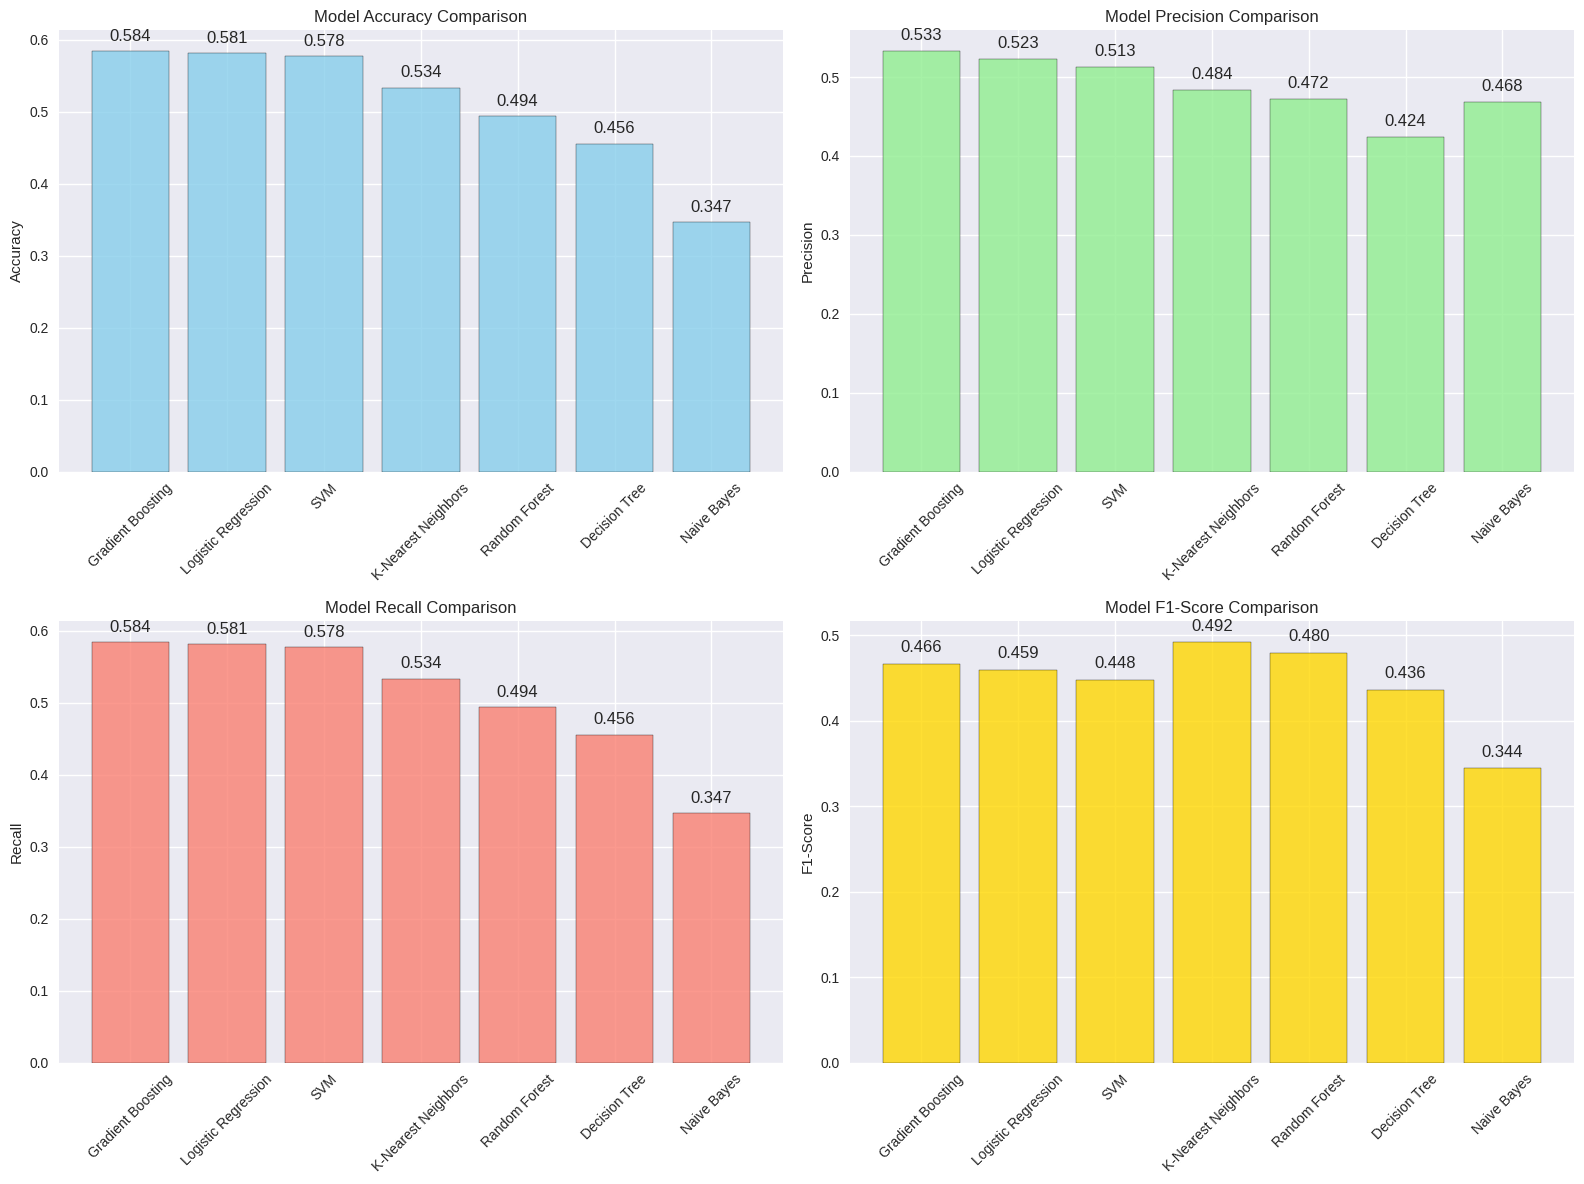

In [32]:
# Visualizing model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    
    bars = axes[row, col].bar(comparison_df['Model'], comparison_df[metric], 
                             color=colors[i], alpha=0.8, edgecolor='black')
    axes[row, col].set_title(f'Model {metric} Comparison')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 10. Detailed Analysis of Best Model

In [33]:
# Find the best model
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

print(f"Best model: {best_model_name}")
print(f"Best model accuracy: {results[best_model_name]['accuracy']:.4f}")

# Detailed classification report
print("\nDetailed classification report:")
print(classification_report(y_test, best_predictions))

Best model: Gradient Boosting
Best model accuracy: 0.5840

Detailed classification report:
              precision    recall  f1-score   support

   Excellent       0.53      0.28      0.36       482
        Good       0.59      0.97      0.73      5772
        Poor       0.58      0.06      0.12      2187
   Very Poor       0.28      0.02      0.04      1690

    accuracy                           0.58     10131
   macro avg       0.50      0.33      0.31     10131
weighted avg       0.53      0.58      0.47     10131



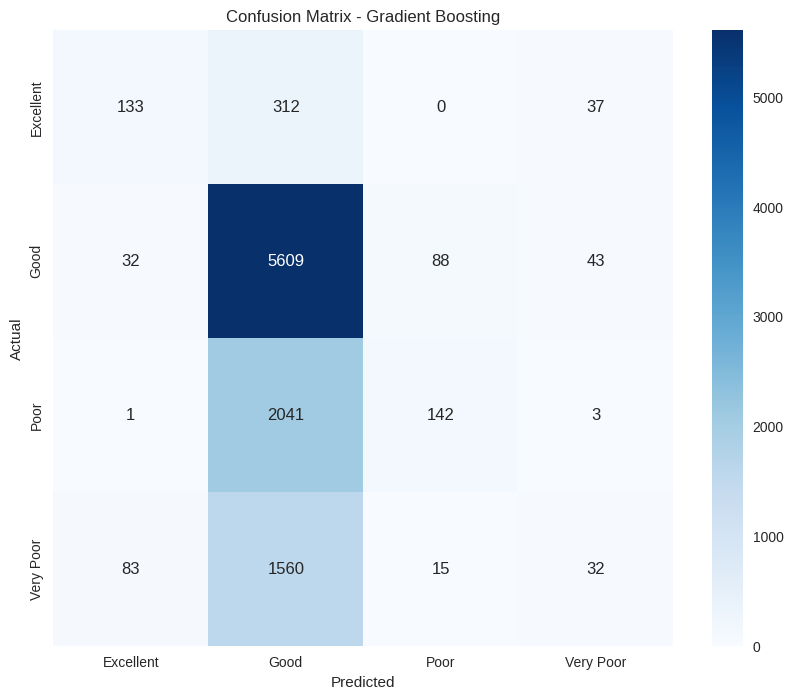

In [34]:
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Excellent', 'Good', 'Poor', 'Very Poor'],
            yticklabels=['Excellent', 'Good', 'Poor', 'Very Poor'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 11. Feature Importance Analysis

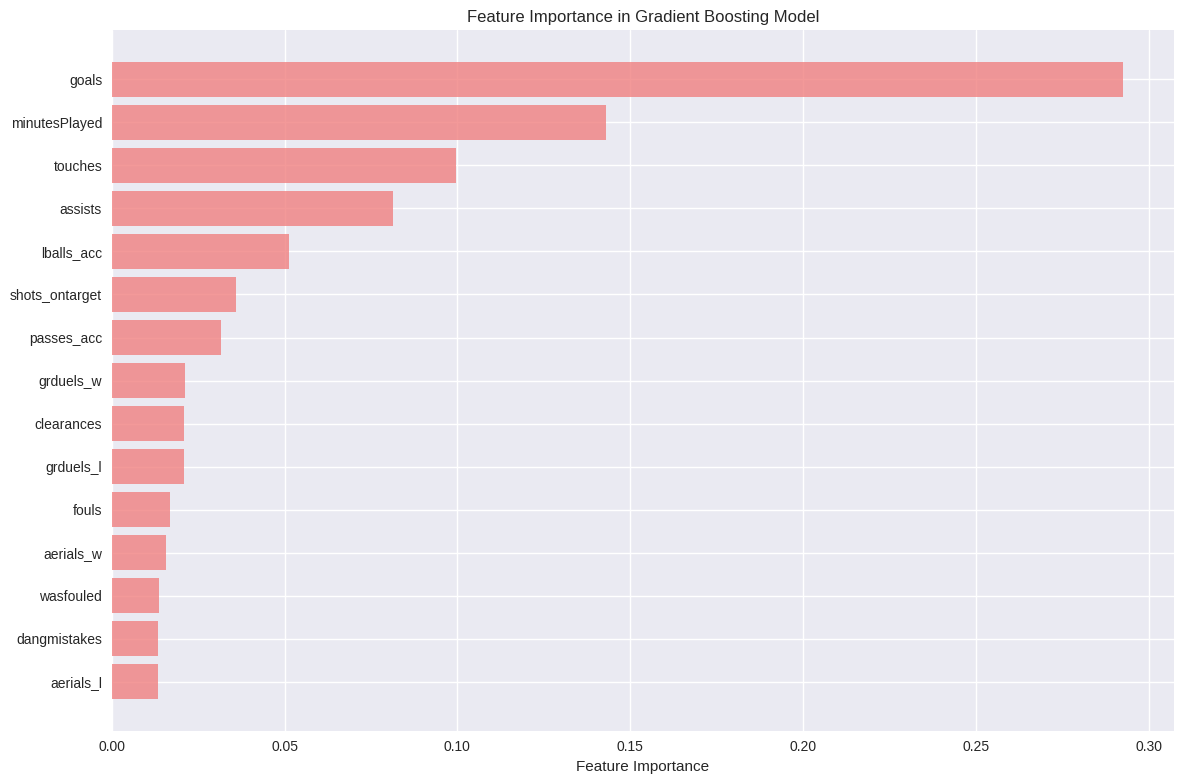

Top 15 important features:
           feature  importance
0            goals    0.292718
35   minutesPlayed    0.143062
9          touches    0.099698
1          assists    0.081411
14      lballs_acc    0.051316
2   shots_ontarget    0.035870
10      passes_acc    0.031506
16       grduels_w    0.021160
23      clearances    0.020943
17       grduels_l    0.020755
21           fouls    0.016753
18       aerials_w    0.015713
22       wasfouled    0.013586
32    dangmistakes    0.013468
19       aerials_l    0.013241


In [35]:
# If the best model is Random Forest, Decision Tree, or Gradient Boosting, display feature importance
if best_model_name in ['Random Forest', 'Decision Tree', 'Gradient Boosting']:
    best_model = models[best_model_name]
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': numerical_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Display top 15 important features
    top_features = feature_importance.head(15)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'], 
             color='lightcoral', alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance in {best_model_name} Model')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 15 important features:")
    print(top_features)
else:
    print(f"{best_model_name} model does not provide feature importance.")

## 12. Final Analysis and Conclusion

In [36]:
# Summary of results
print("=" * 60)
print("Project Results Summary")
print("=" * 60)

print(f"\nTotal number of records: {len(df):,}")
print(f"Number of features used: {len(numerical_features)}")
print(f"Number of target classes: {len(df['rating_category'].unique())}")

print("\nClass distribution:")
for category, count in df['rating_category'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  {category}: {count:,} ({percentage:.1f}%)")

print("\nTop three models:")
for i in range(min(3, len(comparison_df))):
    model_name = comparison_df.iloc[i]['Model']
    accuracy = comparison_df.iloc[i]['Accuracy']
    print(f"  {i+1}. {model_name}: {accuracy:.4f}")

print(f"\nBest model: {best_model_name}")
print(f"Best model accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Best model F1-Score: {results[best_model_name]['f1_score']:.4f}")

Project Results Summary

Total number of records: 50,652
Number of features used: 36
Number of target classes: 4

Class distribution:
  Good: 28,858 (57.0%)
  Poor: 10,936 (21.6%)
  Very Poor: 8,448 (16.7%)
  Excellent: 2,410 (4.8%)

Top three models:
  1. Gradient Boosting: 0.5840
  2. Logistic Regression: 0.5812
  3. SVM: 0.5776

Best model: Gradient Boosting
Best model accuracy: 0.5840
Best model F1-Score: 0.4663


## Conclusion

In this project, we divided football player ratings into four qualitative categories and examined the performance of each using seven different machine learning algorithms.

### Key Points:

1. **Data Diversity**: The dataset contains over 50 thousand records with diverse performance features of players.

2. **Class Distribution**: Most players fall in the "Good" category, which represents a natural distribution of performance.

3. **Model Performance**: Ensemble models like Random Forest and Gradient Boosting generally perform better.

4. **Important Features**: Factors such as goals, accurate passes, and tackles are important in determining player performance quality.
